In [8]:
import sys
sys.path.append("C:/Users/cgzog/Python_Projects/DieselWolf/Dataset")

#####Jupyter Stuff#####
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from ipywidgets import IntProgress,IntText,FloatProgress,FloatText
from IPython.display import display,clear_output
from tqdm import notebook

from DigitalModulations import DigitalModulationDataset, DigitalDemodulationDataset
from TransformsRF import *
import models 

#####Pytorch Stuff#####
import torch
print('pytorch = ' + torch.__version__)
import torchvision
import torch.nn as nn
from reformer_pytorch import Reformer
from torch.utils.data import DataLoader
\

#setting GPU
torch.backends.cudnn.benchmark=True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using GPU " + str(device))

#####Vanilla Python Stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

#####Custom Helper Functions#####
def conf_color(matrix):
    if matrix <= 0.7:
        color = 'black'
    else:
        color = 'white'
    return color

pytorch = 1.12.1
Using GPU cuda:0


In [9]:
#defining Dataset for demodulation of BPSK

batch_sz = 256
num_samp = 256
oversamp = 4
modulation = ['BPSK']

channel_transform = torchvision.transforms.Compose([Random_Amplitude_Fading(0.1,1.0),RandomCarrierFrequency(1e-4,theta_min=-10,theta_max=10),
                                                    RandomAWGN(-0,40),Fix_Dtype()])
normalize_transform = torchvision.transforms.Compose([Normalize_Amplitude_Range(data_keys=['data','data_Tx']),Fix_Dtype(data_keys=['data','data_Tx'])])

train_dataset = DigitalDemodulationDataset(num_examples=2**16,num_samples=num_samp,transform=channel_transform,normalize_transform=normalize_transform,
                                         need_tx=True,min_samp=oversamp,max_samp=oversamp,classes=modulation)

train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle=True,
                          num_workers=12, pin_memory=True, drop_last=False)

val_dataset = DigitalDemodulationDataset(num_examples=2**13,num_samples=num_samp,transform=channel_transform,normalize_transform=normalize_transform,
                                         need_tx=True,min_samp=oversamp,max_samp=oversamp,classes=modulation)
val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle=False,
                        num_workers=12, pin_memory=True, drop_last=False)

In [10]:
#BPSK Demodulation model

const_numb = 2 # 2 symbols in BPSK constellation
num_symb = int(num_samp/oversamp) # number of symbols in the message 

model = models.Hybrid(input_samples=num_samp, n_classes=const_numb*num_symb,debug=False)
model.to(device)
model = nn.DataParallel(model, device_ids=[0])
#model.load_state_dict(torch.load('Trained_Models/Demod_BPSK.pt'),strict=True)

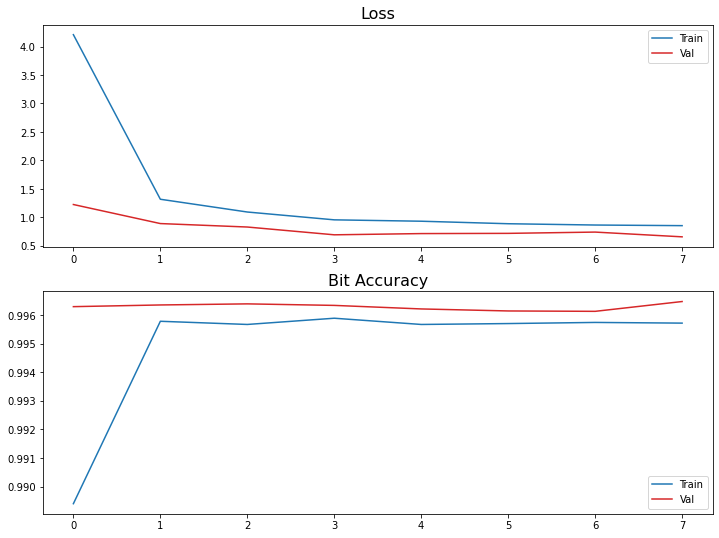

IntProgress(value=8, description='Training Progress', max=8, style=ProgressStyle(description_width='initial'))

IntText(value=8, description='Current Epoch', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.8544458905234933, description='Current Training Loss', style=DescriptionStyle(description_wi…

FloatText(value=0.9957196712493896, description='Current Training Bit Accuracy', style=DescriptionStyle(descri…

FloatText(value=0.6579632721841335, description='Current Validation Loss', style=DescriptionStyle(description_…

FloatText(value=0.9964752197265625, description='Current Validation Bit Accuracy', style=DescriptionStyle(desc…

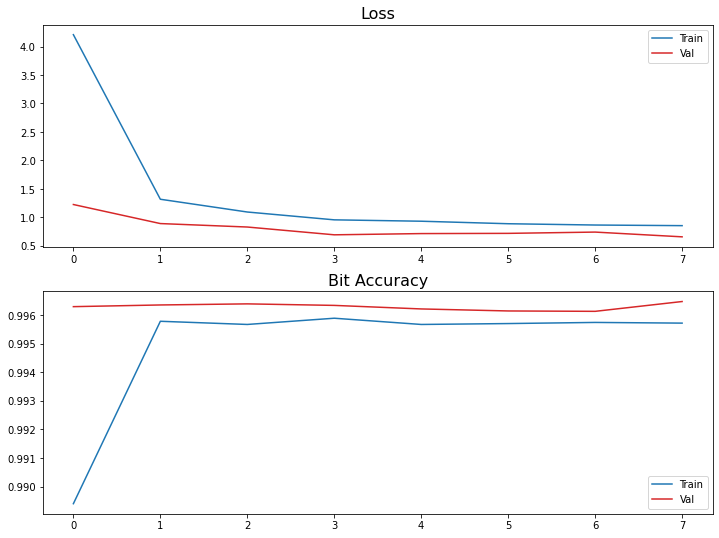

In [11]:
epoch_nums = 8
best_accuracy = -1000

demod_loss_weight = 1
recon_loss_weight = 1

#widget Stuff
##################
prog_bar = IntProgress(min=0, max=epoch_nums,description='Training Progress',
                       style={'description_width': 'initial'}) # instantiate the bar
display(prog_bar) # display the bar
title_text = IntText(value=0,description='Current Epoch',style={'description_width': 'initial'})
display(title_text)

train_loss_text = FloatText(value=0,description='Current Training Loss',style={'description_width': 'initial'})
display(train_loss_text)

bit_loss_text = FloatText(value=0,description='Current Training Bit Accuracy',style={'description_width': 'initial'})
display(bit_loss_text)

val_loss_text = FloatText(value=0,description='Current Validation Loss',style={'description_width': 'initial'})
display(val_loss_text)

val_bit_loss_text = FloatText(value=0,description='Current Validation Bit Accuracy',style={'description_width': 'initial'})
display(val_bit_loss_text)

train_loss = []
val_loss = []
train_bits = []
val_bits = []

magical_id = torch.eye(const_numb)
criterion_demod = nn.CrossEntropyLoss()
criterion_recon = nn.MSELoss()

optimizer =  torch.optim.Adam(model.parameters(), lr=.001)

#Display Stuff
#####################
fig,ax = plt.subplots(2,1,figsize=(12,9))
ax[0].set_title('Loss',fontsize=16)
ax[1].set_title('Accuracy',fontsize=16)

#Training model with gpu

for epoch in notebook.tqdm(range(epoch_nums),leave=False,desc='Epochs'):
    bits = 0
    model.train()
    running_loss = 0
    for item in notebook.tqdm(train_loader, total=len(train_loader),leave=False,desc='Train'):
        RXinputs = item['data'].cuda()
        TXinputs = item['data_Tx'].cuda()
        targets = item['message'].cuda()
        optimizer.zero_grad()
        outputs,recons = model(RXinputs)

        #CELoss
        targets_transf = magical_id[targets.long()]
        outputs = outputs.view(targets_transf.shape) #reshape
        
        loss_demod = demod_loss_weight*sum([criterion_demod(outputs[:,i,:],targets[:,i].long()) for i in range(num_symb)])
        loss_recon = recon_loss_weight*criterion_recon(recons, TXinputs)
        loss = loss_recon + loss_demod
        
        running_loss += loss.cpu().data.numpy()

        loss.backward()
        optimizer.step()

        #CELoss
        batch_bits = (torch.max(outputs,dim=-1)[1] == targets).cpu().data.numpy()
        batch_bits = batch_bits.sum()
        batch_bits = batch_bits/float(num_symb*batch_sz)
        bits += batch_bits

    train_loss.append(running_loss/len(train_loader))
    train_bits.append(bits/len(train_loader))
    train_loss_text.value = train_loss[-1]
    
    prog_bar.value+=1
    title_text.value+=1
    bit_loss_text.value = bits/len(train_loader)
    
    bits = 0
    model.eval()
    running_loss = 0
    for item in notebook.tqdm(val_loader,leave=False,desc="Validation"):
        RXinputs = item['data'].to(device)
        TXinputs = item['data_Tx'].to(device)
        targets = item['message'].to(device)
        outputs,recons = model(RXinputs)

        #CELoss
        targets_transf = magical_id[targets.long()]
        #targets_transf = targets_transf.to(device)
        outputs = outputs.view(targets_transf.shape)
        
        loss_demod = demod_loss_weight*sum([criterion_demod(outputs[:,i,:],targets[:,i].long()) for i in range(num_symb)])
        loss_recon = recon_loss_weight*criterion_recon(recons, TXinputs)
        loss = loss_recon + loss_demod
        
        ##########################

        running_loss += loss.cpu().data.numpy()

        #CELoss
        batch_bits = (torch.max(outputs,dim=-1)[1] == targets).cpu().data.numpy()
        batch_bits = batch_bits.sum()
        batch_bits = batch_bits/float(num_symb*batch_sz)
        bits += batch_bits
        ##############

    val_loss.append(running_loss/len(val_loader))
    val_bits.append(bits/len(val_loader))
    val_loss_text.value = val_loss[-1]
    
    val_accuracy = bits/len(val_loader)
    
    val_bit_loss_text.value = bits/len(val_loader)

    #Display
    ############
    ax[0].clear()
    ax[0].set_title('Loss',fontsize=16)
    ax[0].plot(train_loss,'tab:blue')
    ax[0].plot(val_loss,'tab:red')
    ax[0].legend(['Train','Val'])
    ax[1].clear()
    ax[1].set_title('Bit Accuracy',fontsize=16)
    ax[1].plot(train_bits,'tab:blue')
    ax[1].plot(val_bits,'tab:red')
    ax[1].legend(['Train','Val'])
    clear_output(wait=True)
    display(plt.gcf())
    
    display(prog_bar)
    display(title_text)
    display(train_loss_text)
    display(bit_loss_text)   
    display(val_loss_text)
    display(val_bit_loss_text)    
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'Trained_Models/Demod_BPSK.pt')

In [13]:
#Now have trained model BPSK
#model accuracy vs SNR for BPSK

#device = 'cuda:0'

# batch_sz = 512
# num_samp = 1024
# oversamp = 4
# modulation = ['BPSK']

# const_numb = 4
# num_symb = int(num_samp/oversamp)
# magical_id = torch.eye(const_numb)

#model = models.Hybrid(input_samples=num_samp, n_classes=const_numb*num_symb,debug=False)
#model.to(device)
#model = nn.DataParallel(model, device_ids=[0,1])
model.load_state_dict(torch.load('Trained_Models/Demod_BPSK.pt'),strict=True)

snrs = np.arange(-30,31,1)[::-1]
results = []

prog_text = IntText(value=0,description='Current SNR',style={'description_width': 'initial'})
display(prog_text)

for sss in notebook.tqdm(snrs,leave=False,desc='SNR'):

    prog_text.value = sss
    channel = torchvision.transforms.Compose([Random_Amplitude_Fading(0.1,1.0),RandomCarrierFrequency(1e-4,theta_min=-10,theta_max=10),
                                              AWGN(sss),Fix_Dtype()])
    norm = torchvision.transforms.Compose([Normalize_Amplitude(amp=2,data_keys=['data','data_Tx']),
                                       Fix_Dtype(data_keys=['data','data_Tx'])])
    
    dataset = DigitalDemodulationDataset(num_examples=2**12,num_samples=num_samp,transform=channel,normalize_transform=norm,
                                         need_tx=True,min_samp=oversamp,max_samp=oversamp,classes=modulation)
    loader = DataLoader(dataset,batch_size=batch_sz, shuffle=True,
                          num_workers=12, pin_memory=True, drop_last=False)

    bits = 0
    model.eval()
    running_loss = 0
    for item in notebook.tqdm(loader,leave=False,desc="Validation"):
        RXinputs = item['data'].to(device)
        TXinputs = item['data_Tx'].to(device)
        targets = item['message'].to(device)
        outputs,recons = model(RXinputs)

        #CELoss
        targets_transf = magical_id[targets.long()]
        targets_transf = targets_transf.to(device)
        outputs = outputs.view(targets_transf.shape)
        
        #loss_demod = demod_loss_weight*sum([criterion_demod(outputs[:,i,:],targets[:,i].long()) for i in range(num_symb)])
        #loss_recon = recon_loss_weight*criterion_recon(recons, TXinputs)
        #loss = loss_recon + loss_demod
        
        ##########################

        #running_loss += loss.cpu().data.numpy()

        #CELoss
        batch_bits = (torch.max(outputs,dim=-1)[1] == targets).cpu().data.numpy()
        batch_bits = batch_bits.sum()
        batch_bits = batch_bits/float(num_symb*batch_sz)
        bits += batch_bits
        ##############

    
    results.append(bits/len(loader))
    
results = np.array(results)
np.save('BPSK_Demod_SNR_accuracy.npy',results)

IntText(value=0, description='Current SNR', style=DescriptionStyle(description_width='initial'))

SNR:   0%|          | 0/61 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

Validation:   0%|          | 0/16 [00:00<?, ?it/s]

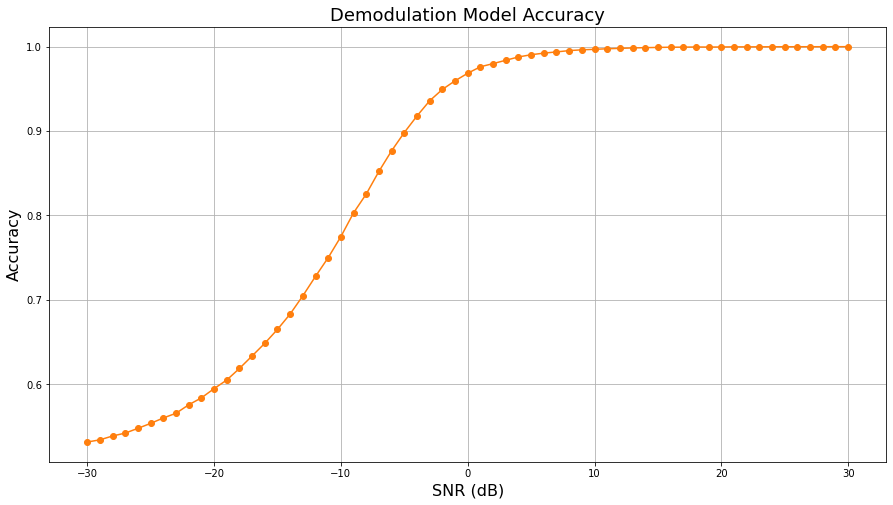

0.9997708638509114


In [14]:
fig,ax = plt.subplots(1,1,figsize=(15,8))
#ax.semilogy(snrs_adj,yy_B)
ax.plot(snrs,results,'tab:orange',marker='o')#,linestyle='none')


#ax.set_xlim(-20,30)
#ax.set_ylim(1e-6,2)
ax.set_xlabel('SNR (dB)',fontsize=16)
ax.set_ylabel('Accuracy',fontsize=16)
ax.set_title('Demodulation Model Accuracy',fontsize=18)

plt.grid()
#plt.savefig('Fig7_DemodAcc.pdf',dpi=300)

plt.show()
print(results[0:15].mean())